# Exercício em Python - Tema 8 - Mudanças Climáticas

O objetivo deste exercício é comparar as séries observadas com os sinais projetados por modelos CMIP5/CMIP6.

## 1.Importação de Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests, io

## 2. Importação da Base de Dados

In [14]:
modelList = ['ACCESS-CM2','ACCESS-ESM1-5','CMCC-ESM2','EC-EARTH3',
             'GFDL-CM4','GFDL-ESM4','HadGEM3-GC31-LL','INM-CM4_8',
             'INM-CM5','IPSL-CM6A-LR','KACE','KIOST','MIROC6','MPI-ESM1-2',
             'MRI-ESM2','NESM3','NorESM2-MM','TaiESM1','UKESM1-0-LL']

scenList = ['hist','ssp245','ssp585']

# Criar dicionário para guardar os DataFrames
df_dict = {}

# Importa base de dados para cada cenário
for scen in scenList:
    # Monta a URL do arquivo já consolidado para o cenário
    url = f"https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CLIMBra_dataset_1/pr-CABra1-{scen}.csv"
    
    # Faz o download do arquivo
    r = requests.get(url).content
    
    # Lê em dataframe
    df = pd.read_csv(io.StringIO(r.decode('utf-8')))

    # Converte a coluna 'time' para datetime e define como índice
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Guarda no dicionário
    df_dict[scen] = df

    #Confirma a importação    
    print(f"Arquivo {scen} importado com sucesso. Dimensões: {df.shape}")


Arquivo hist importado com sucesso. Dimensões: (12419, 19)
Arquivo ssp245 importado com sucesso. Dimensões: (31411, 19)
Arquivo ssp585 importado com sucesso. Dimensões: (31411, 19)


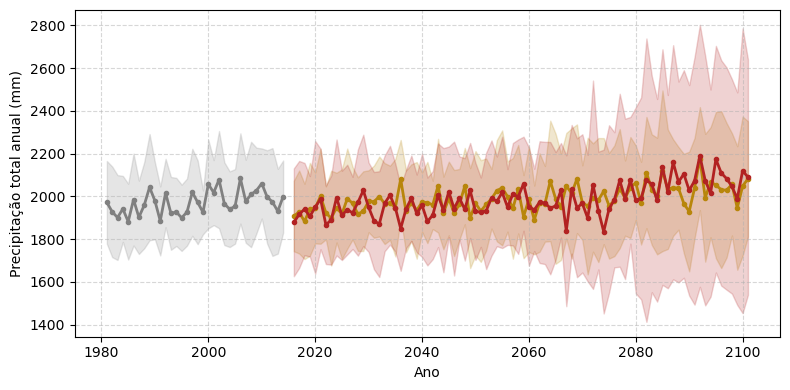

In [15]:
scenList = ['hist','ssp245','ssp585']
colorList  = ['gray','darkgoldenrod','firebrick']

fig, axes = plt.subplots(figsize = (8,4))

for i, scen in enumerate(scenList):
    # Acessa o DataFrame do cenário atual
    df = df_dict[scen]
    
    # Calculando a precipitação total anual
    df_sum = df.resample("YE").sum()
    
    # Calculando estatísticas do ensemble
    ensemble_mean = df_sum.mean(axis=1)
    ensemble_std  = df_sum.std(axis=1)
    
    # Plotando ensemble mean
    plt.plot(ensemble_mean.index, ensemble_mean.values,  marker = 'o', markersize = 3,
             color=colorList[i], linewidth=2)
    
    # Faixa de incerteza (±1 std)
    plt.fill_between(ensemble_mean.index, 
                     ensemble_mean - ensemble_std, 
                     ensemble_mean + ensemble_std, 
                     color=colorList[i], alpha=0.2)

# Formatação do eixo x (anos)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xlabel("Ano")
plt.ylabel("Precipitação total anual (mm)")
# plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()